In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.animation as animation
import numpy as np
from PIL import Image
import pybullet as p
import io

from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset

### Quaternion Multiplication

In [3]:
def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

### Plot to Array Utils

In [4]:
def plt2arr(fig, draw=True):
    """
    need to draw if figure is not drawn yet
    """
    if draw:
        fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))
    return rgba_arr

### Dataset to plot

In [5]:
skill = 'rotate_red_block_right'
dataset = CALVINDynSysDataset(skill=skill, state_type='pos_ori', is_quaternion=True, train=True, normalized=False, goal_centered=False, demos_dir='data/')

In [6]:
buffer = 0.05
minx = min(dataset.X[:, :, 0].flatten().numpy()) - buffer
maxx = max(dataset.X[:, :, 0].flatten().numpy()) + buffer

miny = min(dataset.X[:, :, 1].flatten().numpy()) - buffer
maxy = max(dataset.X[:, :, 1].flatten().numpy()) + buffer

minz = min(dataset.X[:, :, 2].flatten().numpy()) - buffer
maxz = max(dataset.X[:, :, 2].flatten().numpy()) + buffer

### Plotting

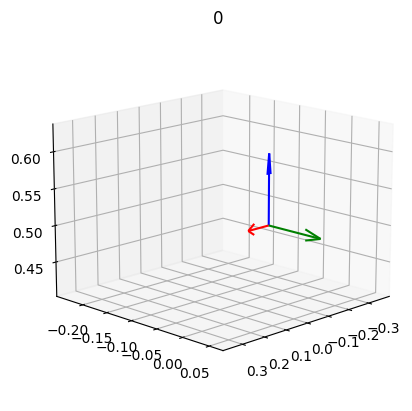

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
# origin = [0, 0, 0]
origin = dataset.X[0][0][:3]
OX, OY, OZ = zip(origin) 

ax.quiver(OX, OY, OZ, X[0],X[1], X[2], color='red')
ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
ax.quiver(OX, OY, OZ, Z[0],Z[1],Z[2], color='blue')
# ax.scatter(OX, OY, OZ, color='gray')
ax.view_init(elev=15, azim=45)
ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
ax.set_title("0")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.show()
plt.close(fig)

In [8]:
frames = []
X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
rand_idx = np.random.randint(0, len(dataset.X)-1)
traj = dataset.X[rand_idx].numpy()
for idx, row in enumerate(traj):
    pos = row[:3]
    OX, OY, OZ = zip(pos) 
    ori = row[3:]
    q = p.getQuaternionFromEuler(ori)
    q = np.array([q[-1], q[0], q[1], q[2]])
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    for i in range(idx):
        ax.scatter(traj[i][0], traj[i][1], traj[i][2], color='gray')
    
    ax.view_init(elev=15, azim=60)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title(skill + ' - ' + str(idx+1))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    frames.append(plt2arr(fig, True))
    plt.close(fig)
    X = [1/10, 0, 0]
    Y = [0, 1/10, 0]
    Z = [0, 0, 1/10]

gif = [Image.fromarray(img) for img in frames]
gif[0].save(f"quat_demo_{skill}.gif", save_all=True, append_images=gif[1:], duration=150, loop=0)
print(rand_idx)

46
